# Full detector-classifier pipeline
1. Crop terns images from train folder {rot, sat, unknown}.

2. Train a resnet-50 classifier based on those images. *During training, the classifier has NO ACCESS to any test images.*

3. Validate the trained classifier on the val/test set that's cropped according to GROUND TRUTH annotations.

4. Validate the trained classifier on the val/test set that's cropped according to DETECTOR resulting boxes.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import cv2
import numpy as np
import pandas as pd
from glob import glob 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.optim
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import DataLoader

from utils.confmat import plot_confusion_matrix
from utils.pipeline2 import train_test_split, TernsDataset, train_model


In [2]:
device = torch.device('cuda')

data_root = './data/22F/'
tile_fold_name = 'split'
crop_fold_name = 'tcrop'
tile_fd = os.path.join(data_root, tile_fold_name)
crop_fd = os.path.join(data_root, crop_fold_name)


for phase in ['Train', 'Validate', 'Test']:
    crop_fd_split = os.path.join(crop_fd, phase)
    if os.path.exists(crop_fd_split):
        continue
    os.makedirs(crop_fd_split, exist_ok=True)
    
    for i, f_til in tqdm(enumerate(sorted(glob(os.path.join(tile_fd, f'{phase}/*'))))):
        ext = f_til.split('.')[-1]
        if not ext.lower() in ['jpg', 'jpeg']:
            continue
        f_ann  = f_til.replace(ext, 'csv')
        df_ann = pd.read_csv(f_ann)
        img_til = cv2.imread(f_til)
        plt.imshow(img_til)

        for ii, df_img in df_ann.iterrows():
            img_crp = img_til[df_img.y:(df_img.y+df_img.height), df_img.x:(df_img.x+df_img.width)]
            img_lab = 'OTH' if df_img.class_id not in ['ROT', 'SAT'] else df_img.class_id

            img_sname = os.path.join(os.path.dirname(f_til).replace(tile_fold_name, crop_fold_name), 
                         f'{os.path.basename(f_til)[:-len(ext)]}{ii:04d}_{img_lab}.{ext}')
            cv2.imwrite(img_sname, img_crp)

# plt.imshow(img_crp)

In [3]:
# csv
for phase in ['Train', 'Validate', 'Test']:
    fn_csv = os.path.join(crop_fd, f'{phase}.csv')
    if os.path.exists(fn_csv):
        continue
    df_dataset = pd.DataFrame(columns={'filename', 'class'})

    for f_img in tqdm(sorted(glob(os.path.join(crop_fd, f'{phase}/*')))):
        ext = f_img.split('.')[-1]
        if not ext.lower() in ['jpg', 'jpeg']:
            continue
        fln = os.path.basename(f_img)
        lab = fln.split('_')[-1].split('.')[0]

        df_dataset.loc[len(df_dataset.index)] = {'filename':fln, 'class':lab}

    df_dataset.to_csv(fn_csv, index=False)
    
# split images cropped from training tiles
train_test_split(os.path.join(crop_fd, 'Train.csv'), rseed=0)

ds_train = pd.read_csv(os.path.join(crop_fd, 'Train-train.csv'))
class_count = ds_train[['class']].value_counts()
class_count

class
ROT      4855
SAT      2898
OTH       377
dtype: int64

In [4]:

batch_size = 1000
n_epochs = 50
learningRate = 1e-4

cost_function = torch.nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, 3)

# optimizer = torch.optim.SGD(model.parameters(), lr = learningRate, momentum=0.9, weight_decay=5e-6, nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr = learningRate, weight_decay=5e-6)

UNI_SIZE = 48
class Flatten(object):
    def __call__(self, input_tensor):
        return input_tensor.view(3, UNI_SIZE, UNI_SIZE)

train_transform = transforms.Compose([transforms.Resize((UNI_SIZE, UNI_SIZE)),
                                transforms.RandomResizedCrop(UNI_SIZE),
                                transforms.RandomHorizontalFlip(), # data augmentation
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform = transforms.Compose([transforms.Resize((UNI_SIZE, UNI_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# datasets
training   = TernsDataset(os.path.join(crop_fd, 'Train-train.csv'), 
                          root_dir  = os.path.join(crop_fd, 'Train'), 
                          transform = train_transform)
validation = TernsDataset(os.path.join(crop_fd, 'Train-valid.csv'),
                          root_dir  = os.path.join(crop_fd, 'Train'), 
                          transform = transform)

# data loaders
train_loader = torch.utils.data.DataLoader(training, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 8)
val_loader = torch.utils.data.DataLoader(validation, 
                                         batch_size = batch_size, 
                                         shuffle = False)


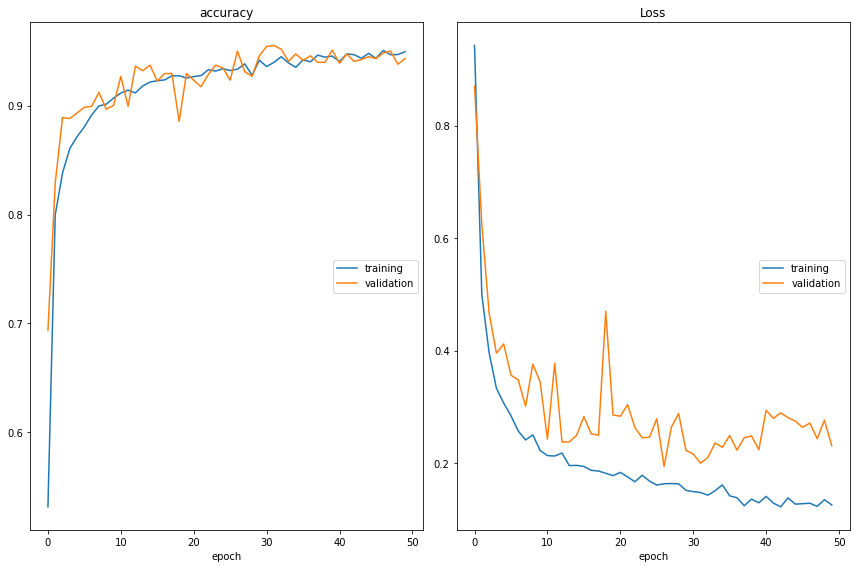

accuracy
	training         	 (min:    0.532, max:    0.951, cur:    0.950)
	validation       	 (min:    0.694, max:    0.955, cur:    0.943)
Loss
	training         	 (min:    0.122, max:    0.942, cur:    0.126)
	validation       	 (min:    0.194, max:    0.870, cur:    0.231)


In [5]:
# save model to
mod_file = './output/example/resnet50_2class/best_model.pth'
save_dir = os.path.dirname(mod_file)
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok = True)

train_model(batch_size, n_epochs, learningRate, model, cost_function, 
            optimizer, -1,  train_loader, val_loader, mod_file, device);

## Annotation test set results (cropped by ground truth boxes)

In [31]:
testing = TernsDataset(os.path.join(crop_fd, 'Test.csv'),
                       root_dir  = os.path.join(crop_fd, 'Test'), 
                       transform = transform)
test_loader = torch.utils.data.DataLoader(testing, 
                                         batch_size = batch_size, 
                                         shuffle = False)

model.load_state_dict(torch.load(mod_file))
model.to(device)
model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    # Run the model on the validation set to keep track of accuracy there.
    for (batch_id, (xb, yb)) in enumerate(test_loader):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        logits = model(xb)
        proba  = logits.detach().softmax(dim = 1)
        
        y_true.append(yb.cpu().numpy())
        y_prob.append(proba.cpu().numpy())
    
y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob, -1)


2272

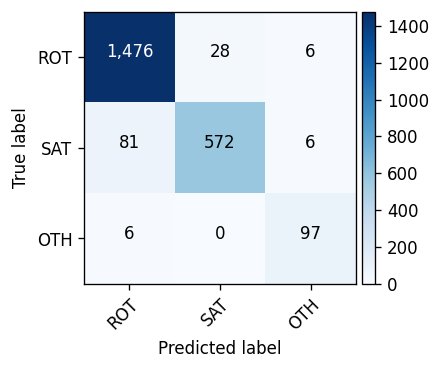

In [32]:
cm_test = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=120)
plot_confusion_matrix(cm_test, ['ROT', 'SAT', 'OTH'], figure=(fig, ax), normalize=False)
cm_test.sum()

## Detector test set results (cropped by detector-predicted boxes)

In [19]:
import shutil
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog
from utils.hyperparameter import setup_default
from utils.dataloader import register_dataset
from utils.confmat import confusion_matrix_report

#Retrieve training parameters
det_dir = './output/example/faster_rcnn_2class_set_I_aug_wloss/faster_rcnn_R_50_FPN_1x-20221208-203023'
with open(os.path.join(det_dir, 'parameters.txt')) as f:
    cfg_parms = json.loads(f.read())
cfg_parms['mod_dirname'] = det_dir
cfg = setup_default(cfg_parms)
cfg.MODEL.WEIGHTS = os.path.join(det_dir, "model_final.pth")
predictor = DefaultPredictor(cfg)

# Register datasets for detectron2
register_dataset( 
    os.path.join(tile_fd, 'Test'), '.JPEG', cfg_parms['BIRD_SPECIES'], unknown_bird_category = True
)

print('Test inference:')
out_res = os.path.join(os.path.dirname(det_dir), 'predicted_results')
shutil.rmtree(out_res, ignore_errors=True)
os.mkdir(out_res)

# Confusion matrix
pred_total, truth_total = confusion_matrix_report(
    DatasetCatalog.get("birds_species_Test"), 
    predictor, 
    cfg_parms['BIRD_SPECIES'] + ['Unknown Bird'], 
    img_ext  ='JPEG', 
    iou_thre = 0.5, 
    save_to  = out_res
)


[12/08 21:56:48 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

Test inference:


  0%|          | 0/141 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [28]:
# cropped birds based on detector predictions
out_dir = out_res
lab_cat2cls = {0: 'ROT', 1: 'SAT', 2: 'OTH'}

df_dataset = pd.DataFrame(columns={'filename', 'class'})
for f_pred_img in tqdm(sorted(glob(os.path.join(out_res, '*')))):
    ext = f_pred_img.split('.')[-1]
    if not ext.lower() in ['jpg', 'jpeg']:
        continue
    fln = os.path.basename(f_pred_img)
    df_dataset.loc[len(df_dataset.index)] = {
        'filename': fln, 
        'class'   : lab_cat2cls[int(fln.split('_')[-1].split('.')[0])]
    }
        
df_dataset.to_csv(os.path.join(out_dir, 'Test.csv'), index=False) 

# pre-correction detector results
y_true_det = []
y_pred_det = []
for fn in df_dataset.filename:
    y_true_det.append(int(fn.split('.')[-2].split('_')[-1]))
    y_pred_det.append(int(fn.split('.')[-3].split('_')[-1]))
    
cm_det = confusion_matrix(y_true_det, y_pred_det)

  0%|          | 0/2541 [00:00<?, ?it/s]

In [29]:
testing_dect = TernsDataset(os.path.join(out_dir, 'Test.csv'), 
                          root_dir  = out_dir, 
                          transform = transform)

test_loader_dect = torch.utils.data.DataLoader(testing_dect, 
                                         batch_size = batch_size, 
                                         shuffle = False)

model.load_state_dict(torch.load(mod_file))
model.to(device)
model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    # Run the model on the validation set to keep track of accuracy there.
    for (batch_id, (xb, yb)) in enumerate(test_loader_dect):

        # Move data to GPU if needed.
        xb = xb.to(device)
        yb = yb.to(device)

        # Compute predictions.
        logits = model(xb)
        proba  = logits.detach().softmax(dim = 1)
        
        y_true.append(yb.cpu().numpy())
        y_prob.append(proba.cpu().numpy())
    
y_true = np.concatenate(y_true)
y_prob = np.concatenate(y_prob)
y_pred = np.argmax(y_prob, -1)
cm = confusion_matrix(y_true, y_pred)


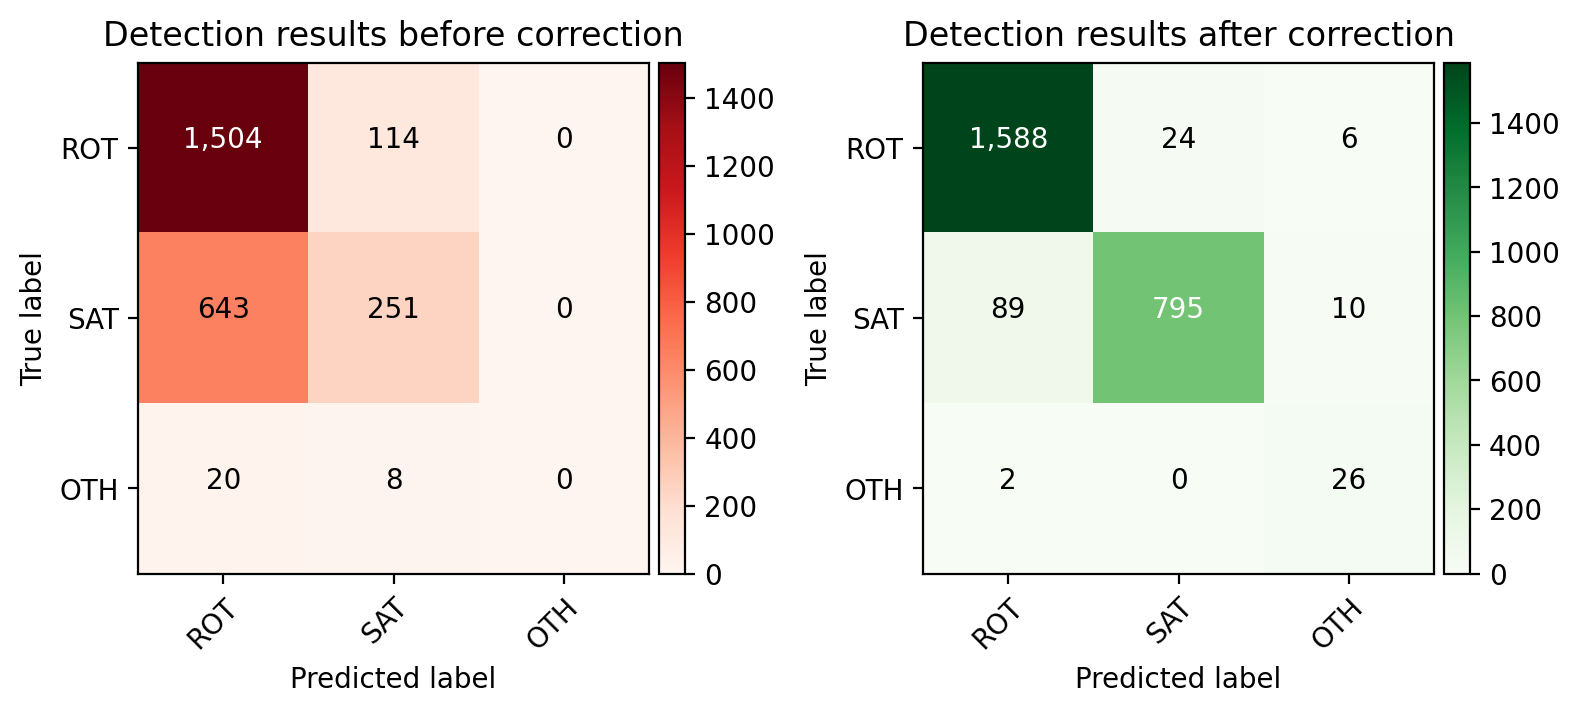

In [30]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=200)

plot_confusion_matrix(
    cm_det, ['ROT', 'SAT', 'OTH'], figure=(fig, ax[0]), normalize=False, cmap = plt.get_cmap('Reds')
)
ax[0].set(title = 'Detection results before correction')

plot_confusion_matrix(
    cm, ['ROT', 'SAT', 'OTH'], figure=(fig, ax[1]), normalize=False, cmap = plt.get_cmap('Greens')
)
ax[1].set(title = 'Detection results after correction')

plt.tight_layout()
plt.show()